<a href="https://colab.research.google.com/github/jmwolf82/XAI_Healthcare/blob/jwolf_work/Interpretting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model Interpretation for Pretrained ResNet Model

In [1]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
#from GPUtil import showUtilization as gpu_usage

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.models import resnet50

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
CUDA_VISIBLE_DEVICES=0

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
torch.cuda.get_device_name(device)

'Tesla T4'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  2% |  7% |
|  1 | 45% |  1% |


In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3080'

In [6]:
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
#model = torch.load('model_rn50_v2_ft.pth')
model = torch.load('/content/model_rn50_v2_ft.pth')

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  4% |  7% |
|  1 | 78% |  8% |


In [ ]:
model = model.to(device)

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  2% |  7% |
|  1 |  1% |  8% |


In [ ]:
#labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
#with open(labels_path) as json_data:
#    idx_to_labels = json.load(json_data)

In [8]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

#img = Image.open('../model_dev/Data_CMC_COADEL_64_1/val/Nonmitosis/10002.jpg')
img = Image.open('/content/27900.jpg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [9]:
input = input.to(device)
output = model(input) #.to(device)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = str(pred_label_idx.item())
print(output)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

tensor([[0.9898, 0.0102]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted: 0 ( 0.9898397922515869 )


In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  1% |  6% |
|  1 |  1% | 18% |


In [11]:
#print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=1)#, n_steps=200)

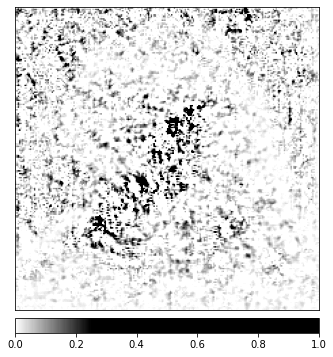

In [16]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  3% |  6% |
|  1 |  0% | 70% |


In [ ]:
from numba import cuda
torch.cuda.empty_cache()

cuda.select_device(1)
cuda.close()
cuda.select_device(1)

<weakproxy at 0x7fee065c31a0 to Device at 0x7fee065cce20>

In [12]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=1)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

RuntimeError: ignored

In [13]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

RuntimeError: ignored

In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage

print("Initial GPU Usage")
gpu_usage()                             

tensorList = []
for x in range(10):
  tensorList.append(torch.randn(10000000,10).cuda())   # reduce the size of tensor if you are getting OOM
  
  

print("GPU Usage after allcoating a bunch of Tensors")
gpu_usage()

del tensorList

print("GPU Usage after deleting the Tensors")
gpu_usage()  

print("GPU Usage after emptying the cache")
torch.cuda.empty_cache()
gpu_usage()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 23% |
|  1 | 19% |  1% |
GPU Usage after allcoating a bunch of Tensors
| ID | GPU | MEM |
------------------
|  0 |  0% | 23% |
|  1 | 63% | 44% |
GPU Usage after deleting the Tensors
| ID | GPU | MEM |
------------------
|  0 |  0% | 23% |
|  1 | 63% | 44% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 23% |
|  1 | 63% |  7% |


In [14]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

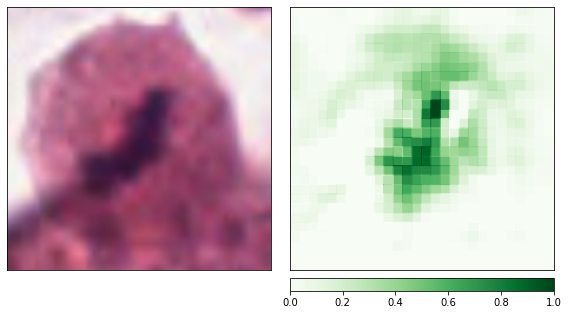

In [15]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

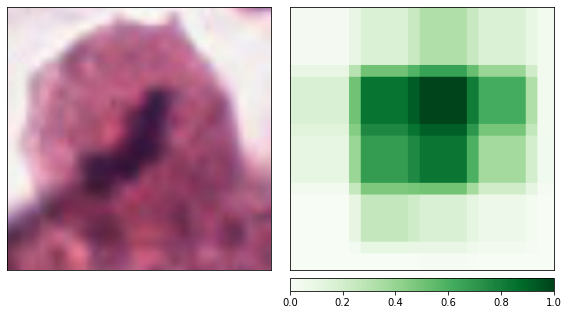

In [16]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )